In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [ ]:
base_dir = '/Volumes/USER_data/Dominik/CECELIA_BACKUP/CV5iNI/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/HYmMxh/')
#im_path = os.path.join(zero_dir, 'ccidImage.ome.zarr')
#im_path = os.path.join(zero_dir, 'ccidCorrected.zarr')
im_path = os.path.join(zero_dir, 'ccidSlidingWindow.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'HYmMxh')

In [2]:
base_dir = '/Volumes/USER_data/Dominik/CECELIA_BACKUP/8BR53W/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/mYdPG4/')
#im_path = os.path.join(zero_dir, 'ccidImage.ome.zarr')
im_path = os.path.join(zero_dir, 'ccidCorrected.zarr')
#im_path = os.path.join(zero_dir, 'ccidSlidingWindow.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), 'mYdPG4')

In [ ]:
from py.napari_utils import NapariUtils

napari_utils = NapariUtils()
napari_utils.open_viewer()
napari_utils.task_dir = task_dir

In [ ]:
channel_names = [
    # 'EB', 'T-A', 'T-B', 'AF', 'gen'
    'One'
]

In [ ]:
napari_utils.open_image(
    im_path,
    use_channel_axis = True, as_dask = True,
    downsample_z = False, squeeze = False
)

In [ ]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    show_tracks = False,
    show_branching = True,
    binarise_labels = True,
    branching_property = 'type',
    value_names = ['SHG', 'SHG.branch']
)

In [3]:
import py.zarr_utils as zarr_utils

In [ ]:
napari_utils.im_data[0].shape

In [ ]:
im = np.average(zarr_utils.fortify(napari_utils.im_data[0][:,3,:,:,:]), axis = 0)
im.shape

In [ ]:
#im = np.average(zarr_utils.fortify(napari_utils.im_data[0][:,5,:,:,:]), axis = 0)[3,:,:]

In [4]:
import py.ILEE_CSK as ILEE_CSK
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

from IPython.utils import io

MATLAB engine not found, bypassing MATLAB module...


In [ ]:
# https://github.com/phylars/ILEE_CSK/wiki/Tutorial
k1 = 2.5
k2 = 500

#img = io.imread('your_path') #substitute to your tiff file path
#img = np.max(zarr_utils.fortify(napari_utils.im_data[0][6,5,:,:,:]), axis = 0)
img = np.copy(im)
img[img < np.percentile(im, 80)] = 0
img = img-img.min()
img = img.astype('float')

# go through z-slices instead of 3D segmentation
im_slices = [slice(None) for _ in range(len(img.shape))]
z_idx = napari_utils.dim_utils.dim_idx('z', ignore_channel = True, ignore_time = True)
diff_im = np.zeros_like(img)

In [5]:
# can you show local anisotropy?
diff, _ = zarr_utils.open_labels_as_zarr(os.path.join(task_dir, 'labels', 'SHG.zarr'))
diff = diff[0]

In [152]:
from skimage.morphology import skeletonize
import skan

img_binary = np.max(zarr_utils.fortify(diff), axis=0)>0
img_sk = skeletonize(img_binary).astype('bool')
radius=20
box_size=radius/2
weighting_method='by_length'
return_box_data=False

sk_data = skan.Skeleton(img_sk)
adj = sk_data.nbgraph
point_list = sk_data.coordinates
shape_tuple = img_sk.shape

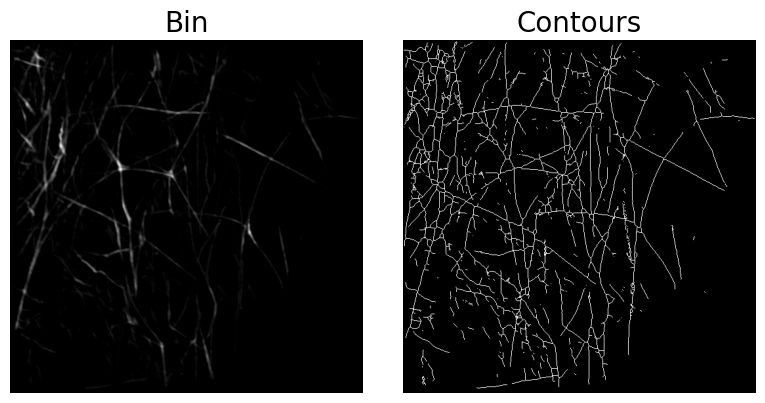

In [153]:
# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(np.max(zarr_utils.fortify(diff), axis=0), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Bin', fontsize=20)

ax[1].imshow(img_sk, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Contours', fontsize=20)

fig.tight_layout()
plt.show()

In [154]:
# get anisotropy
eigval, eigvec, box_total_length, coor_list = ILEE_CSK.anisotropy_2d_internal(
    shape=shape_tuple, adj=adj, point_list=point_list, radius=radius, box_size=box_size)

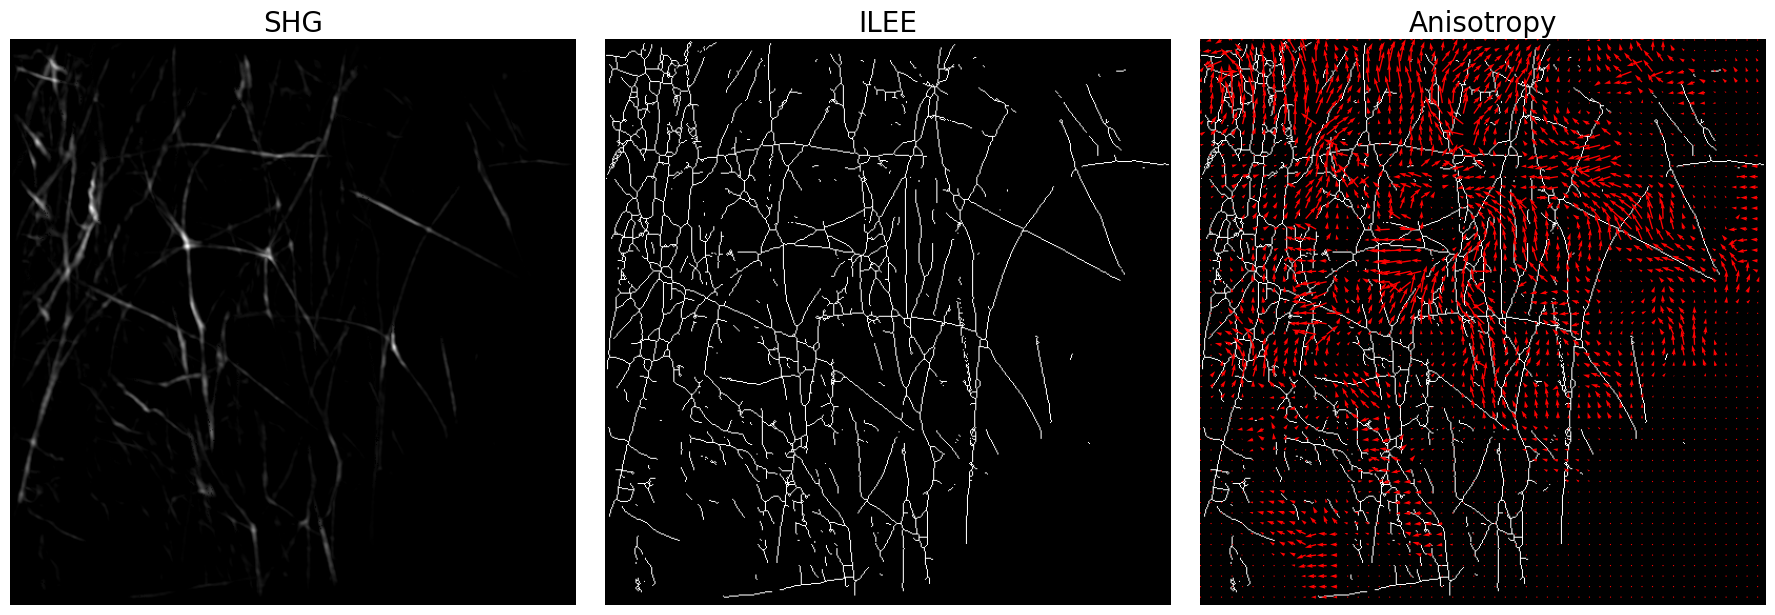

In [155]:
import numpy as np 
import matplotlib.pyplot as plt 

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         sharex=True, sharey=True)

ax = axes.ravel()

x = ax[2]

z_val = 8
ax[0].imshow(np.max(zarr_utils.fortify(diff), axis=0), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('SHG', fontsize=20)

ax[1].imshow(img_sk, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('ILEE', fontsize=20)

ax[2].imshow(img_sk, cmap=plt.cm.gray)
ax[2].quiver(
    coor_list[:,:,0].flatten(),
    coor_list[:,:,1].flatten(),
    eigval[:,:,0].flatten() * eigvec[:,:,0,1].flatten(),
    eigval[:,:,1].flatten() * eigvec[:,:,0,0].flatten(),
    color = 'red'
) 
ax[2].set_aspect('equal', 'box')
ax[2].axis('off')
ax[2].set_title('Anisotropy', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
for i in range(napari_utils.dim_utils.dim_val('z')):
    im_slices = list(im_slices)
    im_slices[z_idx] = slice(i, i+1, 1)
    im_slices = tuple(im_slices)
    
    print(f'>> Process Z: {i}')
    
    # https://stackoverflow.com/a/52559560
    with io.capture_output() as captured:
        diff_im[im_slices] = ILEE_CSK.ILEE_2d(
            np.squeeze(img[im_slices]), k2 = k2, k1 = k1, pL_type = 'pL_8', gauss_dif = True)

# binarise
bin_im = diff_im > 0

In [ ]:
diff_im.dtype

In [ ]:
# get quantification
sk_df = ILEE_CSK.analyze_actin_3d_standard(
    img, diff_im,
    napari_utils.dim_utils.im_physical_size('x'),
    napari_utils.dim_utils.im_physical_size('z'),
    # TODO this takes a long time - not sure this is necessary for our case?
    # oversampling_for_bundle = True,
    oversampling_for_bundle = False,
    pixel_size = napari_utils.dim_utils.im_physical_size('x')
)

In [ ]:
labels.ndim

In [ ]:
from scipy import ndimage as ndi

contours = np.copy(labels)
eroded_labels = np.copy(labels)
thickness = 1
background_label = 0

# go through all z-axis
for i in range(labels.shape[0]):
    cur_labels = labels[i,:,:]
    
    # adapted from from napari
    # https://github.com/napari/napari/blob/996f502a7f94f68275625dd8b9e94978167f63f9/napari/layers/labels/_labels_utils.py#L208
    struct_elem = ndi.generate_binary_structure(cur_labels.ndim, 1)
    thick_struct_elem = ndi.iterate_structure(struct_elem, thickness).astype(bool)

    dilated_labels = ndi.grey_dilation(cur_labels, footprint=struct_elem)
    eroded_labels[i,:,:] = ndi.grey_erosion(cur_labels, footprint=thick_struct_elem)
    not_boundaries = dilated_labels == eroded_labels[i,:,:]

    contours[i,:,:][not_boundaries] = background_label
    eroded_labels[i,:,:] = eroded_labels[i,:,:] - contours[i,:,:]

In [ ]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# perform skeletonization
skeleton = skeletonize(contours)

# now convert to skan
import skan

sk_skeleton = skan.Skeleton(skeleton)
paths_table = skan.summarize(sk_skeleton)

In [ ]:
from skimage.util import invert

bin_labels = np.copy(eroded_labels)
bin_labels[bin_labels > 0] = 2
bin_labels[bin_labels == 0] = 1
bin_labels[bin_labels == 2] = 0

from skimage.morphology import (erosion, dilation, opening, closing,
                                white_tophat)

morph_labels = white_tophat(bin_labels, ndi.generate_binary_structure(bin_labels.ndim, 1))

# perform skeletonization
skeleton = skeletonize(morph_labels)

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

z_val = 8
ax[0].imshow(bin_labels[z_val,:,:], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Bin', fontsize=20)

ax[1].imshow(morph_labels[z_val,:,:], cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Contours', fontsize=20)

ax[2].imshow(np.max(skeleton, axis=0), cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Skeleton', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage.color import label2rgb
from skimage.filters import sobel
from skimage.morphology import dilation, disk
from skimage.measure import label
from skimage.segmentation import expand_labels, watershed

coins = data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# expanded = expand_labels(seg1, distance=10)
expanded = dilation(seg1, disk(20))

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(coins, cmap="Greys_r")
axes[0].set_title("Original")

color1 = label2rgb(seg1, image=coins, bg_label=0)
axes[1].imshow(color1)
axes[1].set_title("Sobel+Watershed")

color2 = label2rgb(expanded, image=coins, bg_label=0)
axes[2].imshow(color2)
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()


In [ ]:
all([True, False])

In [ ]:
import py.slice_utils as slice_utils

In [ ]:
zarr_shape = list(napari_utils.im_data[0].shape)
zarr_shape.pop(napari_utils.dim_utils.dim_idx('C'))

In [ ]:
a = [[.1],[2],[34]]

In [ ]:
a[1].insert(0, 1)

In [ ]:
a

In [ ]:
slice_utils.create_slices(
  zarr_shape, napari_utils.dim_utils, 1000, -1,
  block_size_z = -1, overlap_z = -1)

In [ ]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    show_tracks = False,
    show_branching = True,
    branching_property = 'weight',
    value_names = ['SHG.branch']
)

In [ ]:
napari_utils.show_labels_all(
    show_labels = False,
    show_points = False,
    show_tracks = True,
    value_names = ['P14-CTDR']
)

In [ ]:
# get timescale
napari_utils.time_interval = 0.5

In [ ]:
napari_utils.viewer.text_overlay.position = napa

In [ ]:
def update_slider(event):
    # https://forum.image.sc/t/napari-how-add-a-text-label-time-always-in-the-same-spot-in-viewer/52932/5
    time = napari_utils.viewer.dims.current_step[0]
    napari_utils.viewer.text_overlay.text = str(datetime.timedelta(seconds = time * napari_utils.time_interval * 60))

import datetime

napari_utils.viewer.text_overlay.position
napari_utils.viewer.text_overlay.visible = True
napari_utils.viewer.text_overlay.font_size = 12
napari_utils.viewer.text_overlay.color = 'white'
napari_utils.viewer.dims.events.current_step.connect(update_slider)

In [ ]:
napari_utils.im_scale

In [ ]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    show_tracks = False,
    value_names = ['manual'],
    as_np_array = True
)

In [ ]:
# show populations
napari_utils.show_pop_mapping('live')

In [ ]:
# save image as tiff
import py.tiff_utils as tiff_utils

tiff_utils.save_as_tiff(
    '/Volumes/USER_data/Dominik/Experiments/TEAGEN_SKIN/DATA/PuJo5p.tif',
    napari_utils.im_data[0], napari_utils.dim_utils, imagej = True)

In [ ]:
print('here')

In [ ]:
napari_utils.im_scale

In [ ]:
from napari_animation import AnimationWidget
animation_widget = AnimationWidget(napari_utils.viewer)
napari_utils.viewer.window.add_dock_widget(animation_widget, area='right')

In [ ]:
pop_type = 'live'
pop_map = napari_utils.pop_utils.pop_map(napari_utils.task_dir, pop_type)
pop_data = napari_utils.pop_utils.pop_data(napari_utils.task_dir, pop_type)

In [ ]:
pop_info = pop_map['5iaWSo']

In [ ]:
pop_info